# Week 10. Data Analysis Examples I

### Outline:

- Introduction to statsmodels  <br>
<br>
- Testing Capital Asset Pricing Model (CAPM)  <br>
<br>
- Predicting Returns in HK Stocks Markets

In [1]:
import numpy as np
import pandas as pd
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(6, 4))
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 15
np.set_printoptions(precision=4, suppress=True)

---

## 10.1 Introduction to statsmodels

```statsmodels``` is a Python library for fitting many kinds of traditional statistical models, performing statistical tests, and data exploration and visualization. 

**Some kinds of models found in statsmodels include:**
* Linear models, generalized linear models, and robust linear models
* Analysis of variance (ANOVA) methods
* Time series processes and state space models
* Generalized method of moments
* ...

### Estimating Linear Models

Linear models in statsmodels have two different main interfaces: **array-based** and **formula-based**.

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In the following codes, I will simulate the endogeneous variable ```y``` as a linear function of three explanatory variables ```X```: <br>
<br>
$$
y_i = c + X^\top_i \beta + \epsilon_i, \ \ i = 1, \dots, N. 
$$
* $\epsilon_i$: residual, random error, etc. 
* $\epsilon_i$ is needed to capture the idea that $X_i$ cannot perfectly explain $y_i$
<br>

We stack the observations in matrices:
$$
y = \begin{pmatrix} 
    y_1 \\
    \vdots \\
    y_N \\
\end{pmatrix}, \ \
X = \begin{pmatrix} 
    x_{11} & x_{12} & x_{13} \\
    \vdots & \vdots & \vdots \\
    x_{N1} & x_{N2} & x_{N3} \\
\end{pmatrix}, \ \
\epsilon = \begin{pmatrix} 
    \epsilon_1 \\
    \vdots \\
    \epsilon_N \\
\end{pmatrix} \implies
y = c \cdot 1_N +  X \beta + \epsilon. 
$$

In [3]:
np.random.seed(123456)
N = 100   # the number of observations
X = np.random.normal(size=(N,3))    # the matrix of independent variables
eps = np.random.normal(scale=0.5, size=(N,1))   # the matrix of random errors
beta = np.array([[0.1, 0.3, 0.5]]).T   # the hypothetical true coefficients
y = X @ beta + eps    # generate dependent variables based on the linear system, assuming a zero constant

* In the above codes, I wrote down the “true” model with known parameters ```beta```. 
   * What is the true value of $c$? <br>
<br>
* In reality, $c$ and $\beta$ are unknown, and we need to estimate these parameters. How do we estimate them? <br>
<br>
* We often rely on the ***ordinary least squares (OLS)*** method: 
$$
\hat{c}, \hat{\beta} = \text{arg min}_{c, \beta} \sum^N_{i=1} \big(y_i - c - X_i^\top \beta \big)^2. 
$$
  * You do not need to know the estimation details. 
  * Instead, you are required to understand how to perform the OLS estimation using ```statsmodels``` package. 

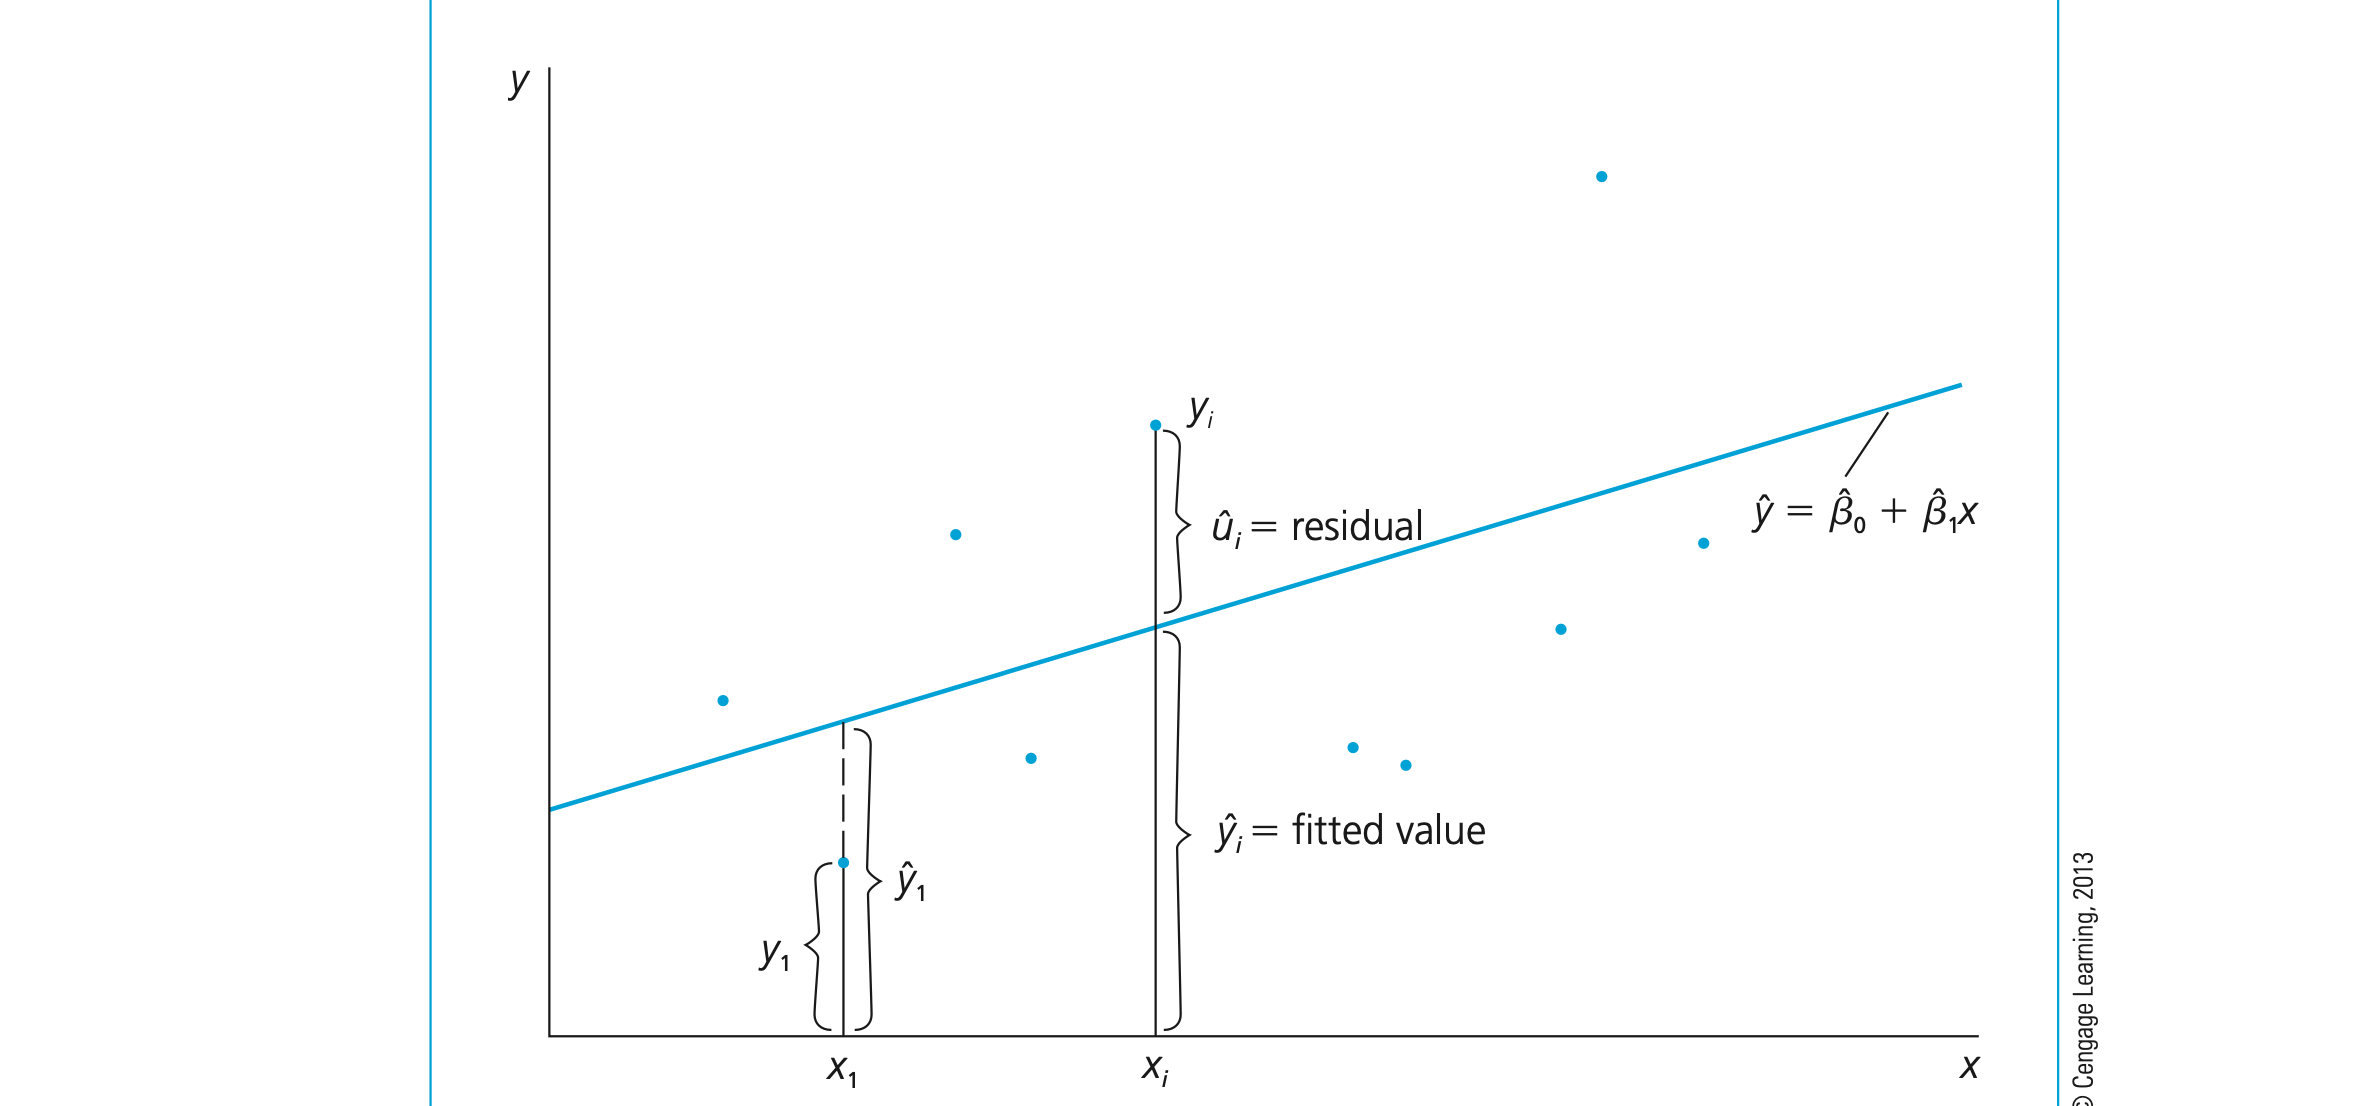

The ```sm.OLS``` class can fit an ordinary least squares linear regression:
  * The ```sm.add_constant``` function can add an intercept column to an existing matrix:

In [4]:
sm.add_constant(X)[:5]

array([[ 1.    ,  0.4691, -0.2829, -1.5091],
       [ 1.    , -1.1356,  1.2121, -0.1732],
       [ 1.    ,  0.1192, -1.0442, -0.8618],
       [ 1.    , -2.1046, -0.4949,  1.0718],
       [ 1.    ,  0.7216, -0.7068, -1.0396]])

In [5]:
model = sm.OLS(y, sm.add_constant(X))   # create an instance
print(type(model))   # you can think of the object model as an equation, but you need to estimate it later!

<class 'statsmodels.regression.linear_model.OLS'>


The model’s ```fit``` method returns regression results object containing estimated model parameters and other diagnostics:

In [6]:
results = model.fit()   # fit the model via OLS

In [7]:
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

In [8]:
results.params

array([-0.0985,  0.0726,  0.3436,  0.6229])

In [9]:
print("OLS estimates of common intercept:", results.params[0])
print("True values of common intercept:", 0.0)

print("OLS estimates of beta:", results.params[1:])
print("True values of beta:", beta.T)

OLS estimates of common intercept: -0.09848359133040084
True values of common intercept: 0.0
OLS estimates of beta: [0.0726 0.3436 0.6229]
True values of beta: [[0.1 0.3 0.5]]


The ```summary``` method on ```results``` can print a model detailing diagnostic output of the model:

In [10]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     78.75
Date:                Thu, 23 Nov 2023   Prob (F-statistic):           8.77e-26
Time:                        16:42:01   Log-Likelihood:                -72.188
No. Observations:                 100   AIC:                             152.4
Df Residuals:                      96   BIC:                             162.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0985      0.052     -1.888      0.0

#### How to interpret the above table? 
* The ```coef``` column shows the **point estimates** of $(c, \beta)$.  <br>
<br>
* The ```R-squared``` column shows the in-sample fit:
$$
R^2_{in} = 1 - \frac{\sum^N_{i=1} \big(y_i - \hat{c} - X_i^\top \hat{\beta} \big)^2}{\sum^N_{i=1} \big(y_i - \bar{y} \big)^2}. 
$$
  * We want to minimize the sum of squared errors, $\sum^N_{i=1} \big(y_i - \hat{c} - X_i^\top \hat{\beta} \big)^2$, and therefore maximize $R^2_{in}$. 
  * ```R-squared``` is 0.711 in this dataset.  <br>
<br>
* The ```std err``` column shows the **standard errors of OLS estimates** of $(c, \beta)$: the squared root of $\text{var} (\hat{c})$ and $\text{var} (\hat{\beta})$.  <br>
<br>
* We also have the **interval estimates** of $(\hat{c}, \hat{\beta})$. 
  * For example, the $[2.5\%, 97.5\%]$ interval estimates of ```x1``` and ```x2``` are $[-0.058, 0.177]$ and $[0.080, 0.290]$, which quantifies the uncertainty in OLS estimation. 
  * Rough interpretation: the true value of $\beta_2$ of ```x2``` will take the value in the interval $[0.080, 0.290]$ with $95\%$ probability. <br>
<br>

* Hypothesis testing via p-values (see the ```P>|t|``` column):
  * Null hypothesis: $\beta = 0$
  * P-values are related to Type-I error: If the true value of $\beta$ is zero (the null hypothesis is true), we can obtain the observed data (OLS estimates) with the probability of the p-value. 
    * When p-values are tiny, we often reject the null hypothesis. For instance, the p-value in the ```x2``` row is around $0.1\%$, which implies that if the true $\beta_2 = 0$, we will obtain the point estimate of $\hat{\beta}_2 = 0.1852$ with a probability of only $0.1\%$. 

We can also use the ```formula-based``` way. 
 * We also do not need to use ```add_constant``` when using formulas.

In [11]:
data = pd.DataFrame(X, columns=['col0', 'col1', 'col2'])
data['y'] = y
data.head()

,col0,col1,col2,y
0,0.469112,-0.282863,-1.509059,-1.345953
1,-1.135632,1.212112,-0.173215,-0.305403
2,0.119209,-1.044236,-0.861849,-1.501160
3,-2.104569,-0.494929,1.071804,0.454846
4,0.721555,-0.706771,-1.039575,-1.798304


In [12]:
results = smf.ols('y ~ col0 + col1 + col2', data=data).fit()

In [13]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     78.75
Date:                Thu, 23 Nov 2023   Prob (F-statistic):           8.77e-26
Time:                        16:42:02   Log-Likelihood:                -72.188
No. Observations:                 100   AIC:                             152.4
Df Residuals:                      96   BIC:                             162.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0985      0.052     -1.888      0.0

In [14]:
def get_R2(beta_hat, y, X):
    """
    beta_hat: a pandas.Series of coefficient estimates
    y: an ndarray of dependent variables
    X: a two-dimensional ndarray of independent variables
    This function returns the R-squared in the linear models
    """
    pred_err = y.reshape((len(y),)) - sm.add_constant(X) @ beta_hat
    return 1 - (y.reshape(N,) - sm.add_constant(X) @ beta_hat).var() / y.var()
    

In [15]:
print("In-sample R-squared", get_R2(results.params, y, sm.add_constant(X)))

In-sample R-squared 0.7110608328059598


### Out-of-Sample Fit

* In the previous analysis, we mentioned the (in-sample) R-squared.  <br>
<br>
* However, what we really care about is the **out-of-sample (OOS)** performance. <br>
<br>
* In other words, how does the model predict the values of ```y``` for the unobserved ```X``` (that is not used in the OLS estimation). 

#### Let's simulate another random sample (*use a different random seed*):

In [16]:
np.random.seed(4523)  
N_oos = 100
X_oos = np.random.normal(size=(N_oos,3))
eps_oos = np.random.normal(scale=0.5, size=(N_oos,1))
beta = np.array([[0.1, 0.3, 0.5]]).T
y_oos = X_oos @ beta + eps_oos

data_oos = pd.DataFrame(X_oos, columns=['col0', 'col1', 'col2'])
data_oos['y'] = y_oos
data_oos.head()

,col0,col1,col2,y
0,-1.183021,-0.886086,-0.612342,-0.027758
1,0.559865,-1.541225,1.167640,0.532127
2,-0.693965,-0.492440,-0.833246,0.306403
3,1.773236,0.094788,1.164182,1.260211
4,0.784778,0.130953,-0.233733,-0.596281


Given new **out-of-sample** data, you can compute predicted values given the estimated model parameters:

In [17]:
print("Out-of-sample R-squared", get_R2(results.params, y_oos, sm.add_constant(X_oos)))

Out-of-sample R-squared 0.540701111066256


### Final remark

* Understand the difference between in- and out-of-sample performance <br>
<br> 
* Can always increase the in-sample performance by including more predictors in your model <br>
<br>
* Out-of-sample performance is the gold standard in investment!

---

## 10.2 Capital Asset Pricing Model (CAPM)

We next use the ```statmodel``` to test the Capital Asset Pricing Model (CAPM). 

The risk-return tradeoff is a fundamental object that we want to understand in finance. For example, 
* how do we measure the risk of a stock, e.g., Apple? 
* What is the expected return of Apple? 

To answer this question, practitioners rely on different models. The CAPM is one of these benchmark models in the industry. 

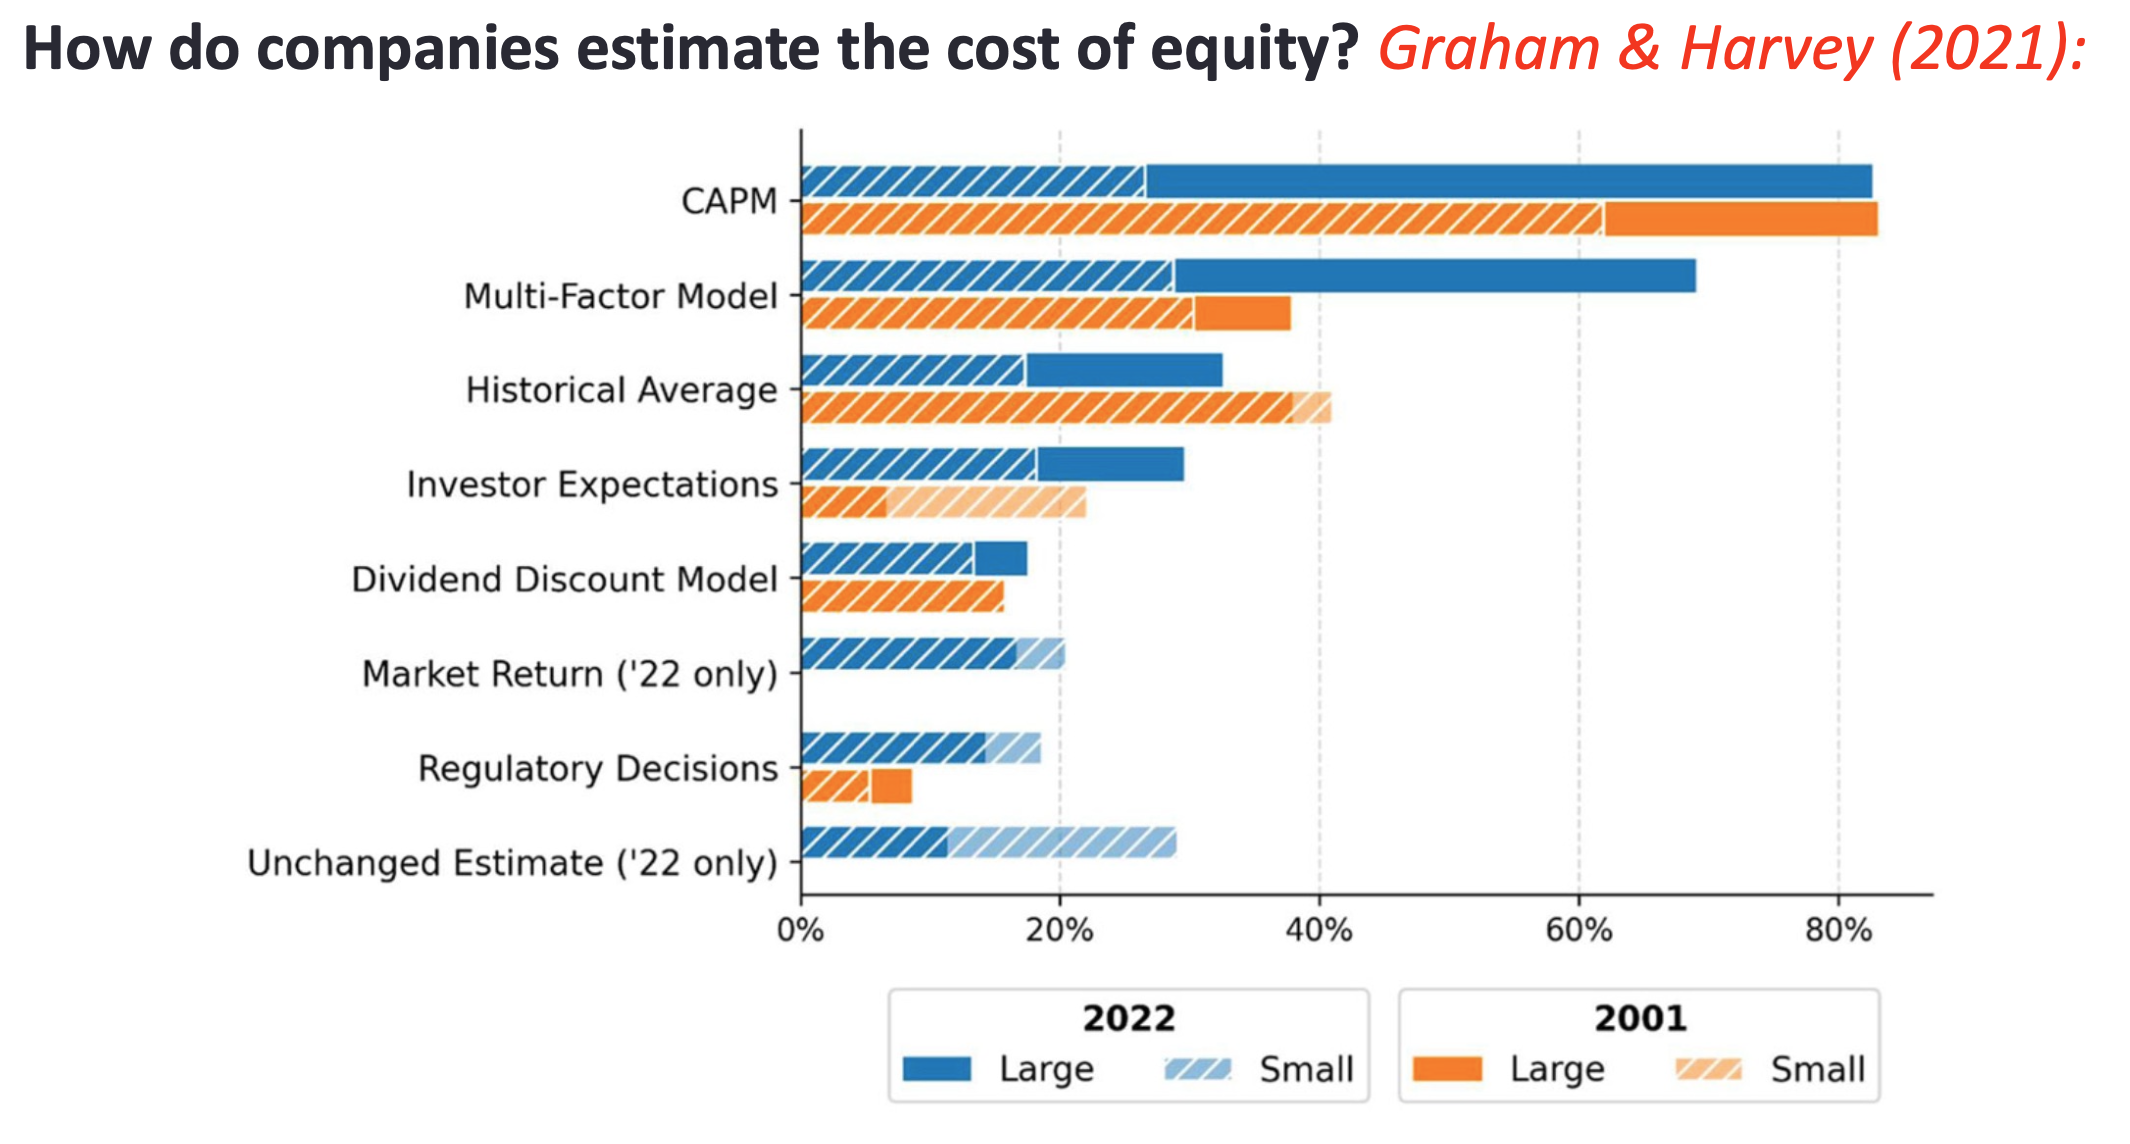

What is the CAPM? It conjectures that the required return of an asset should be determined by the **systematic risk** as follows: <br>
<br>
$$
\mathbf{E} [ R_i ] - R_f = \beta_i \big( \mathbf{E} [ R_m ] - R_f \big), 
$$
 * $\mathbf{E} [ R_i ]$: the expected/required return of the asset $i$
 * $R_f$: the risk-free rate
 * $\mathbf{E} [ R_m ]$: the expected/required return of the market portfolio ($m$ is the abbreviation for market)
 * $\beta_i = \frac{\text{cov} (R_i - R_f, R_m - R_f)}{\text{var} (R_m - R_f)}$: the beta, or the sensitivity of the expected excess return to the expected excess market return

In other words, the larger the $\beta_i$ is, the riskier the asset is $\implies$ higher expected return. 

Total variance of an asset is ***NOT*** the right measure of investment risk. 

### Is CAPM a reasonable benchmark model?

We estimate the CAPM via the simple OLS regression that we just introduced:   <br>
<br>
$$
R_{it} - R_{ft} = \alpha_i + \beta_i \big( R_{mt} - R_{ft} \big) + \epsilon_{it}, 
$$
 * $R_{it}$, $R_{mt}$, and $R_{ft}$: the time-$t$ return of asset $i$, the market portfolio, and the risk-free asset
 * $\epsilon_{it}$: the random error term, with $\mathbf{E} \big[ \epsilon_{it} \mid R_{mt} - R_{ft} \big] = 0$
 * $\alpha_i$ is called the pricing errors (or just the alpha)
   * If the CAPM holds, $\alpha_i$ should be close to zero for any asset $i$
   * The null hypothesis is $H_0: \alpha_i = 0$ for any asset $i$ (The correct way is to test the joint hypothesis that $H_0: \alpha_1 = \dots = \alpha_N = 0$. However, this is outside the scope of this course)

### 10.2.1 Read the data

* The data file is ```"data/week10_test_assets.xlsx"```, with two sheets:
  * ```"25portfolios_size_value"```: the daily returns of 25 portfolios
  * ```"FF3_factors"```: the daily factors, with four columns:
    * ```'Mkt-RF'```: the daily market excess return
    * ```'SMB'```: the daily size factor return
    * ```'HML'```: the daily value factor return
    * ```'RF'```: the daily risk-free rate
  * All return or rate variables are in the unit of $\%$: For example, $-0.51$ means that the daily return is $-0.0051$ or $-0.51\%$

In [18]:
test_assets_daily = pd.read_excel("data/week10_test_assets.xlsx", 
                                  sheet_name="25portfolios_size_value",
                                  index_col=0)
test_assets_daily.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
19630701,-0.51,-0.81,-0.66,-0.58,-0.73,-0.87,-0.70,-0.37,-0.44,-0.83,...,-0.65,-0.52,-0.49,-0.93,-0.79,-0.63,-0.70,-0.63,-0.63,-1.30
19630702,0.51,0.94,0.28,0.59,0.62,0.72,0.24,0.77,0.61,0.86,...,0.88,0.52,0.52,1.33,0.30,0.84,0.82,0.84,0.82,1.38
19630703,0.80,0.52,0.71,0.50,0.35,0.46,0.60,0.54,0.38,0.57,...,0.78,0.38,0.51,0.50,1.12,0.65,0.60,0.97,0.65,0.38
19630705,0.29,0.23,0.69,0.40,0.40,0.77,0.73,0.41,0.18,0.25,...,0.46,0.00,0.24,-0.03,0.32,0.57,0.20,1.03,0.14,0.18
19630708,-0.42,-0.22,-0.63,-0.26,-0.49,-0.87,-0.92,-0.71,-0.56,-0.96,...,-0.22,-0.24,-0.49,-0.62,-0.70,-0.80,-0.44,-0.39,-0.81,-1.09


In [19]:
test_assets_daily.isnull().sum().sum()

0

In [20]:
test_assets_daily.describe()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
count,15103.000000,15103.000000,15103.000000,15103.000000,15103.000000,15103.000000,15103.000000,15103.000000,15103.000000,15103.000000,...,15103.000000,15103.000000,15103.000000,15103.000000,15103.000000,15103.000000,15103.000000,15103.000000,15103.000000,15103.000000
mean,0.024573,0.049891,0.050984,0.060199,0.065025,0.039198,0.052508,0.056661,0.057990,0.062714,...,0.047235,0.046923,0.050585,0.055684,0.057184,0.045917,0.044005,0.045512,0.042654,0.050507
std,1.339662,1.212168,1.089802,1.065907,1.049387,1.367209,1.186639,1.116985,1.104997,1.238125,...,1.215350,1.045459,1.039834,1.064524,1.261505,1.118752,1.040419,1.046984,1.153437,1.377860
min,-13.670000,-13.360000,-12.950000,-14.590000,-11.630000,-15.470000,-13.310000,-11.680000,-12.350000,-14.260000,...,-15.730000,-16.600000,-15.660000,-13.930000,-17.940000,-18.440000,-20.580000,-18.840000,-20.350000,-18.300000
25%,-0.550000,-0.460000,-0.410000,-0.350000,-0.350000,-0.590000,-0.480000,-0.410000,-0.390000,-0.470000,...,-0.510000,-0.420000,-0.400000,-0.410000,-0.480000,-0.500000,-0.435000,-0.430000,-0.460000,-0.550000
50%,0.100000,0.100000,0.100000,0.100000,0.110000,0.110000,0.100000,0.090000,0.090000,0.100000,...,0.090000,0.080000,0.090000,0.090000,0.080000,0.060000,0.050000,0.050000,0.050000,0.050000
75%,0.680000,0.620000,0.550000,0.510000,0.510000,0.730000,0.640000,0.560000,0.530000,0.620000,...,0.640000,0.550000,0.550000,0.560000,0.620000,0.590000,0.540000,0.530000,0.560000,0.660000
max,11.440000,10.420000,9.040000,8.870000,14.260000,11.000000,9.440000,8.960000,8.810000,11.040000,...,11.370000,10.950000,12.320000,13.120000,13.800000,12.990000,10.880000,12.430000,13.760000,16.540000


<Axes: >

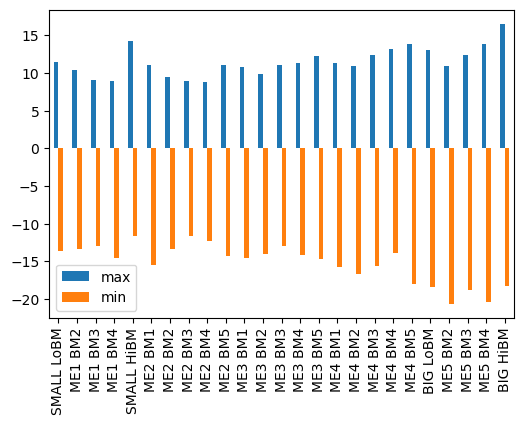

In [21]:
pd.concat((test_assets_daily.max(),test_assets_daily.min()), axis=1, keys=['max','min']).plot.bar()

### Handling the time-series index

In [22]:
test_assets_daily.index

Index([19630701, 19630702, 19630703, 19630705, 19630708, 19630709, 19630710,
       19630711, 19630712, 19630715,
       ...
       20230616, 20230620, 20230621, 20230622, 20230623, 20230626, 20230627,
       20230628, 20230629, 20230630],
      dtype='int64', name='Date', length=15103)

```python
test_assets_daily.index = [str(x) for x in test_assets_daily.index]
```
**Or**
```python
from dateutil.parser import parse
test_assets_daily.index = [parse(x) for x in test_assets_daily.index]
```

In [23]:
test_assets_daily.index = pd.to_datetime(test_assets_daily.index, format='%Y%m%d')

In [24]:
test_assets_daily.index

DatetimeIndex(['1963-07-01', '1963-07-02', '1963-07-03', '1963-07-05',
               '1963-07-08', '1963-07-09', '1963-07-10', '1963-07-11',
               '1963-07-12', '1963-07-15',
               ...
               '2023-06-16', '2023-06-20', '2023-06-21', '2023-06-22',
               '2023-06-23', '2023-06-26', '2023-06-27', '2023-06-28',
               '2023-06-29', '2023-06-30'],
              dtype='datetime64[ns]', name='Date', length=15103, freq=None)

In [25]:
factors_daily = pd.read_excel("data/week10_test_assets.xlsx", sheet_name="FF3_factors", index_col=0)
factors_daily.index = pd.to_datetime(factors_daily.index, format='%Y%m%d')
#factors_daily.index = [str(x) for x in factors_daily.index]
#factors_daily.index = [parse(x) for x in factors_daily.index]
factors_daily.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1963-07-01,-0.67,0.18,-0.35,0.012
1963-07-02,0.79,-0.30,0.28,0.012
1963-07-03,0.63,-0.17,-0.10,0.012
1963-07-05,0.40,0.10,-0.28,0.012
1963-07-08,-0.63,0.06,-0.20,0.012


Let's first divide all returns by 100: 

In [26]:
MKT_RF_daily = factors_daily[['Mkt-RF']]/100
RF_daily = factors_daily[['RF']]/100

MKT_daily = pd.DataFrame(MKT_RF_daily.values+RF_daily.values, 
                         columns=["MKT"], index=MKT_RF_daily.index)
test_assets_daily = test_assets_daily/100

In finance, we often test the CAPM at the monthly frequency, which requires us to transform the daily returns into the monthly ones (**downsampling**). <br>
<br>
$$
R^{month}_i = \prod^D_{d=1} (1 + R^{daily}_i) - 1, 
$$
 * $D$ is the number of days in a month. 

In [27]:
MKT_monthly = (1+MKT_daily).resample('M').prod() - 1
RF_monthly = (1+RF_daily).resample('M').prod() - 1
test_assets_monthly = (1+test_assets_daily).resample('M').prod() - 1

Create the monthly market **excess** return:

In [28]:
MKT_RF_monthly = pd.DataFrame(MKT_monthly.values - RF_monthly.values, 
                              index=MKT_monthly.index, columns=['MKT_RF'])

In [29]:
print("Average (annualized) excess return of the market portfolio:", 12*MKT_RF_monthly.mean())
print("Standard deviation  of (annualized) market excess return:", np.sqrt(12)*MKT_RF_monthly.std())

Average (annualized) excess return of the market portfolio: MKT_RF    0.067683
dtype: float64
Standard deviation  of (annualized) market excess return: MKT_RF    0.155729
dtype: float64


**Sharpe Ratio**

* Also known as the reward-to-variability ratio, measures the performance of an investment. 
* Defined as the difference between the returns of the investment and the risk-free return, divided by the standard deviation of the investment returns. 
$$
\text{SR} = \frac{\mathbf{E} [R_{it} - R_{ft}] }{\sqrt{\text{var} (R_{it} - R_{ft})}}. 
$$
 * For each unit of investment risk (quantified by $\sqrt{\text{var} (R_{it} - R_{ft})}$), investors chase for higher compensations (higher $\mathbf{E} [R_{it} - R_{ft}]$). Therefore, we generally prefer high Sharpe ratio investments. 

In [30]:
print("Annualized Sharpe ratio of the market excess return:", 
      12*MKT_RF_monthly.mean() / (np.sqrt(12)*MKT_RF_monthly.std()))

Annualized Sharpe ratio of the market excess return: MKT_RF    0.434622
dtype: float64


**Cumulative holding-period return of the market portfolio vs risk-free bonds**

In [31]:
print("If you invested $1 in the market portfolio in July 1963, you will get $"
      +str((MKT_monthly+1).cumprod().values[-1][0])
      +" in June 2023")
print("If you invested $1 in the risk-free bond in July 1963, you will get $"
      +str((RF_monthly+1).cumprod().values[-1][0])
      +" in June 2023")

If you invested $1 in the market portfolio in July 1963, you will get $369.63133558022054 in June 2023
If you invested $1 in the risk-free bond in July 1963, you will get $13.429938658680243 in June 2023


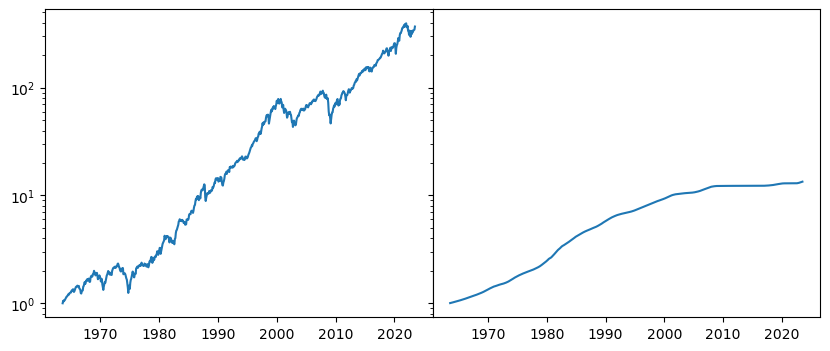

In [32]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
axes[0].plot((MKT_monthly+1).cumprod())
axes[1].plot((RF_monthly+1).cumprod())
plt.yscale("log")
plt.subplots_adjust(wspace=0.0, hspace=0.0)

### 10.2.2 Testing (unconditional) CAPM

* ```test_assets_monthly``` contains the total monthly returns of test assets;
* CAPM uses excess returns in the OLS regressions $\implies$ We need to compute the monthly excess returns for 25 test assets. 

In [33]:
Tm, N = test_assets_monthly.shape
print('Number of monthly observations:', Tm)
print('Number of test assets:', N)

Number of monthly observations: 720
Number of test assets: 25


In [34]:
### I mutate test_assets_RF_monthly in the following operation:
test_assets_RF_monthly = pd.DataFrame(test_assets_monthly.values - RF_monthly.values @ np.ones((1,N)), 
                                      index=test_assets_monthly.index, columns=test_assets_monthly.columns)

#### How to do the broadcasting in ```pandas```?
```python
test_assets_monthly.sub(RF_monthly['RF'], axis='index')
```

#### Consider the *second* test asset, for example:

In [35]:
model = sm.OLS(test_assets_RF_monthly.values[:,1], sm.add_constant(MKT_RF_monthly.values))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     1179.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):          1.35e-153
Time:                        16:42:13   Log-Likelihood:                 1246.8
No. Observations:                 720   AIC:                            -2490.
Df Residuals:                     718   BIC:                            -2480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.529      0.5

In [36]:
results.params

array([0.0009, 1.2214])

In [37]:
results.conf_int(alpha=0.05)

array([[-0.0023,  0.004 ],
       [ 1.1516,  1.2913]])

* Remember that we have 25 OLS regressions, each of which corresponds to one specific test asset. <br>
<br>
* We will create a list, ```results_list```, to store the OLS estimates for 25 assets. 

In [38]:
results_list = []
alpha = np.zeros((N,))
alpha_95CI = np.zeros((2, N))
beta = np.zeros((N,))
beta_95CI = np.zeros((2, N))

for n in range(N):
    model = sm.OLS(test_assets_RF_monthly.values[:,n], sm.add_constant(MKT_RF_monthly.values))
    results = model.fit()
    results_list.append(results)
    alpha[n] = results.params[0]
    beta[n] = results.params[1]
    alpha_95CI[:,n] = results.conf_int(alpha=0.05)[0,:]
    beta_95CI[:,n] = results.conf_int(alpha=0.05)[1,:]
    

In [39]:
alpha

array([-0.0051,  0.0009,  0.0015,  0.0037,  0.0049, -0.0025,  0.0012,
        0.0025,  0.003 ,  0.0035, -0.002 ,  0.0017,  0.0018,  0.0031,
        0.0037, -0.0003,  0.0004,  0.0015,  0.0026,  0.0024,  0.0003,
        0.0003,  0.0009,  0.0001,  0.0011])

In [40]:
beta

array([1.4107, 1.2214, 1.1038, 1.036 , 1.0644, 1.3788, 1.1808, 1.0723,
       1.0166, 1.1444, 1.3044, 1.1232, 1.01  , 0.9988, 1.0789, 1.2014,
       1.0813, 1.0101, 0.9925, 1.0833, 0.9877, 0.9242, 0.8619, 0.8898,
       0.9796])

In [41]:
alpha_95CI

array([[-0.0087, -0.0023, -0.0011,  0.0011,  0.0019, -0.0052, -0.001 ,
         0.0005,  0.001 ,  0.0009, -0.0042, -0.    ,  0.0001,  0.0012,
         0.0012, -0.002 , -0.001 , -0.0001,  0.0008, -0.    , -0.0009,
        -0.0009, -0.0006, -0.0018, -0.0015],
       [-0.0015,  0.004 ,  0.004 ,  0.0063,  0.0079,  0.0002,  0.0034,
         0.0046,  0.0051,  0.0061,  0.0002,  0.0034,  0.0035,  0.0049,
         0.0061,  0.0014,  0.0017,  0.003 ,  0.0044,  0.0048,  0.0015,
         0.0014,  0.0024,  0.002 ,  0.0037]])

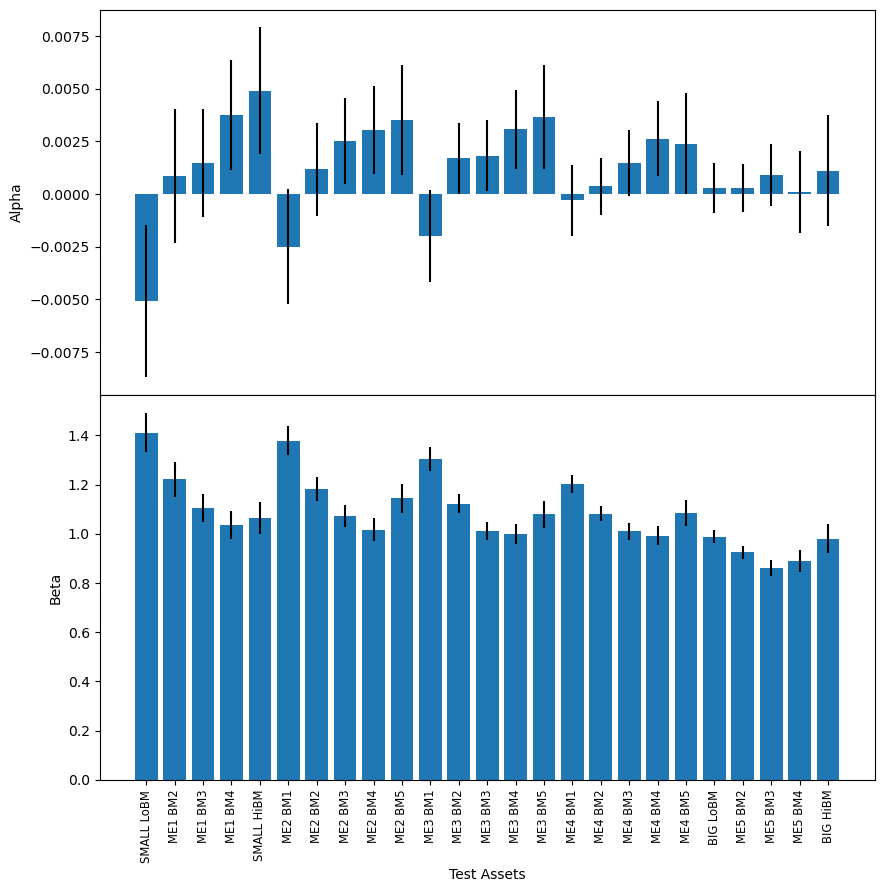

In [42]:
fig, axes = plt.subplots(2, 1, figsize=(10,10), sharex=True)

axes[0].bar(np.arange(1,26,1), alpha, yerr=(alpha-alpha_95CI)[0,:])
axes[0].set_xticks(np.arange(1,26,1))
#axes[0].set_xticklabels(test_assets_monthly.columns, rotation=90, fontsize='small')
#axes[0].set_xlabel('Test Assets')
axes[0].set_ylabel('Alpha')

axes[1].bar(np.arange(1,26,1), beta, yerr=(beta-beta_95CI)[0,:])
axes[1].set_xticks(np.arange(1,26,1))
axes[1].set_xticklabels(test_assets_monthly.columns, rotation=90, fontsize='small')
axes[1].set_xlabel('Test Assets')
axes[1].set_ylabel('Beta')

plt.subplots_adjust(wspace=0.0, hspace=0.0)

* Market betas are strongly identified: The $95\%$ confidence intervals of betas are all positive. <br>
<br>
* We detect some mispricing (significant alphas). 
  * ```SMALL LoNM```, ```ME1 BM3```, ```ME1 HiBM```, etc. 

CAPM implies that the assets with larger betas should command higher average returns. 

**Is the CAPM consistent with the empirical observations?** 

* $\mathbf{E} [ R_m ] - R_f$: ```MKT_RF_monthly.values.mean()```  <br>
<br>
* $\beta_i \cdot \big( \mathbf{E} [ R_m ] - R_f \big)$: ```beta*MKT_RF_monthly.values.mean()```  <br>
<br>
* $\mathbf{E} [ R_i ] - R_f$: ```test_assets_RF_monthly.values.mean(axis=0)```

In [43]:
mean_rets_capm = beta*MKT_RF_monthly.values.mean()
mean_rets_realized = test_assets_RF_monthly.values.mean(axis=0)

Text(0, 0.5, 'Observed realised returns')

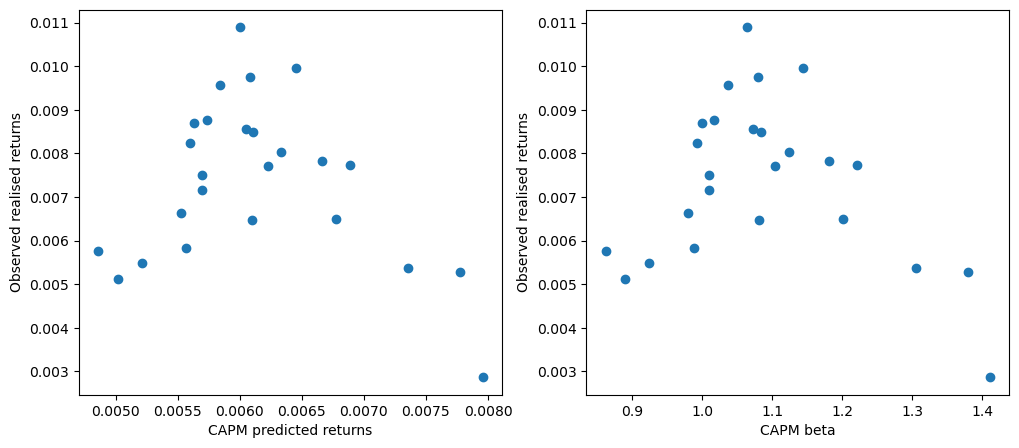

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

axes[0].scatter(mean_rets_capm, mean_rets_realized)
axes[0].set_xlabel('CAPM predicted returns')
axes[0].set_ylabel('Observed realised returns')


axes[1].scatter(beta, mean_rets_realized)
axes[1].set_xlabel('CAPM beta')
axes[1].set_ylabel('Observed realised returns')


### 10.2.3 Time-varying market beta

* One potential reason for the failure of CAPM is that the betas are time-varying in reality. <br>
<br>
* Instead, we should consider a time-varying model as follows: <br>
$$
\mathbf{E}_{t-1} [ R_{it} - R_{ft} ] = \beta_{i,t-1} \cdot \mathbf{E}_{t-1} [ R_{mt} - R_{ft} ] , 
$$
    * $\mathbf{E}_{t-1}$: conditional expectation at time $t-1$
    * $\beta_{i,t-1}$: conditional beta of stock $i$ observed at time $t-1$  <br>
<br>
* In this section, let's use the rolling window to estimate time-varying market betas $\beta_{i,t-1}$ (```rolling``` and ```ewm``` functions).

First, compute the daily excess returns

In [45]:
test_assets_RF_daily = pd.DataFrame(test_assets_daily.values - RF_daily.values @ np.ones((1,N)), 
                                    index=test_assets_daily.index, columns=test_assets_daily.columns)

Let's focus on the **first** test asset (we can extend the same analysis to other 24 assets):

In [46]:
data = pd.merge(test_assets_RF_daily.iloc[:,0], MKT_RF_daily, left_index=True, right_index=True)

#### Suppose now that we want to estimate the beta of asset 1 using a rolling window of 252 trading days:

* We also impose that the minimal number of periods is 100
* Let me remind you of the equation of the market beta:
$\beta_i = \frac{\text{cov} (R_i - R_f, R_m - R_f)}{\text{var} (R_m - R_f)}$

In [47]:
cov_mkt = test_assets_RF_daily.iloc[:,0].rolling(252, min_periods=100).cov(MKT_RF_daily)
var_mkt = MKT_RF_daily.rolling(252, min_periods=100).var()
beta = cov_mkt / var_mkt

<Axes: xlabel='Date'>

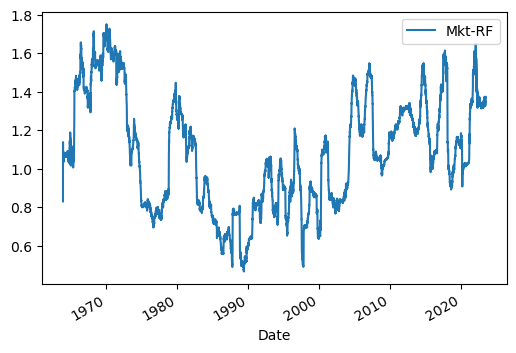

In [48]:
beta.plot()

#### Alternatively, we can adopt the exponentially weighted moving windows:

In [49]:
cov_mkt_ewm = test_assets_RF_daily.iloc[:,0].ewm(252, min_periods=100).cov(MKT_RF_daily)
var_mkt_ewm = MKT_RF_daily.ewm(252, min_periods=100).var()
beta_ewm = cov_mkt_ewm / var_mkt_ewm

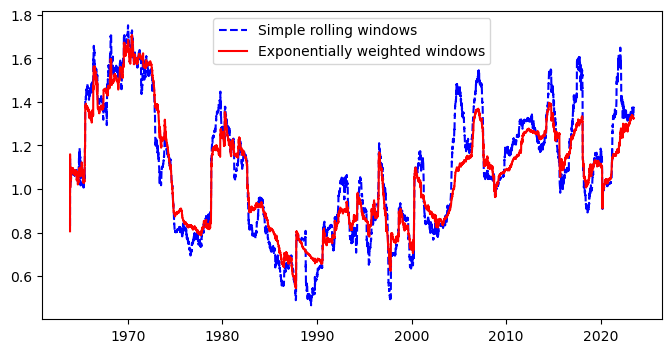

In [50]:
plt.figure(figsize=(8,4))
plt.plot(beta, 'b--', label='Simple rolling windows')
plt.plot(beta_ewm, 'r-', label='Exponentially weighted windows')
plt.legend(loc='best')

#### Time-varying market betas of all 25 test assets

In [51]:
beta_25assets = np.zeros(test_assets_RF_daily.shape)
var_mkt = MKT_RF_daily.rolling(252, min_periods=100).var()

for n in range(beta_25assets.shape[1]):
    data = pd.merge(test_assets_RF_daily.iloc[:,n], MKT_RF_daily, left_index=True, right_index=True)
    cov_mkt = test_assets_RF_daily.iloc[:,n].rolling(252, min_periods=100).cov(MKT_RF_daily)
    beta_25assets[:,n] = (cov_mkt / var_mkt).values[:,0]
    
beta_25assets = pd.DataFrame(beta_25assets)
beta_25assets.index = test_assets_RF_daily.index
beta_25assets.columns = test_assets_RF_daily.columns

In [52]:
beta_25assets.iloc[-5:,:]

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-26,1.346178,1.263975,1.086113,1.075362,0.772078,1.348390,1.285549,1.176338,0.998327,0.951436,...,1.176011,1.078508,0.938875,0.997716,1.016415,1.155411,0.781479,0.827957,0.776132,0.852115
2023-06-27,1.374546,1.281202,1.095765,1.079660,0.775088,1.365779,1.291521,1.179846,1.001657,0.958795,...,1.175555,1.078307,0.939931,0.998097,1.013882,1.158490,0.775614,0.830503,0.769642,0.844983
2023-06-28,1.375094,1.282531,1.096986,1.080701,0.776506,1.365559,1.292054,1.180748,1.003007,0.960287,...,1.175553,1.078767,0.940893,0.998601,1.014674,1.158165,0.775490,0.831000,0.770235,0.845420
2023-06-29,1.374328,1.284399,1.100154,1.087461,0.783269,1.365881,1.293455,1.186340,1.008571,0.971389,...,1.173924,1.081066,0.946996,1.005650,1.029651,1.154555,0.773475,0.833978,0.779142,0.858215
2023-06-30,1.372264,1.282069,1.098158,1.084015,0.779827,1.363244,1.290940,1.182703,1.007773,0.966539,...,1.172842,1.079181,0.945292,1.004136,1.026364,1.155349,0.774357,0.833545,0.778384,0.856522


#### How do we test the conditional CAPM?

$$
\mathbf{E}_{t-1} [ R_{it} - R_{ft} ] = \beta_{i,t-1} \cdot \mathbf{E}_{t-1} [ R_{mt} - R_{ft} ]
$$

Let's focus on two ***indirect*** tests

* $\mathbf{E}_{t-1} [ R_{mt} - R_{ft} ]$ is the conditional market risk premium that should be mostly positive <br>
<br>
* This implies that high $\beta_{i,t-1}$ predicts higher stock returns (larger $\mathbf{E}_{t-1} [ R_{it} - R_{ft} ]$) over the next period  <br>
<br>
* **Test I**. We can regress $R_{it} - R_{ft}$ on $\beta_{i,t-1}$ and test whether the slope coefficient is siginificantly positive <br>
<br>
* **Test II**. We can split the test assets based on $\beta_{i,t-1}$ into five groups, from low-beta to high-beta: high-beta group should earn higher average returns than low-beta ones

### Test I

* Let's convert the daily beta estimates into monthly beta, using the ```resample``` method <br>
<br>
* We need to extract the lagged market beta because we use $\beta_{i,t-1}$ to predict $R_{it} - R_{ft}$

In [53]:
beta_25assets_monthly = beta_25assets.resample('M').mean()

In [54]:
beta_25assets_monthly_lag = beta_25assets_monthly.shift(1)

In [55]:
test_assets_RF_monthly.head()

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1963-07-31,0.008768,-0.005649,0.004375,-0.001973,-0.017295,-0.020426,-0.000891,-0.012591,-0.022321,-0.014595,...,-0.012041,-0.019420,-0.021771,-0.018282,-0.021235,-0.000971,0.002106,0.009727,-0.008461,-0.013614
1963-08-31,0.040023,0.011176,0.012733,0.021555,0.040549,0.053165,0.042667,0.042244,0.041667,0.079879,...,0.052044,0.044971,0.060067,0.074596,0.051024,0.055290,0.040239,0.043544,0.080933,0.061647
1963-09-30,-0.020099,0.003388,-0.012945,-0.018986,-0.006830,-0.043401,-0.017577,-0.011516,-0.017342,-0.031840,...,-0.030767,-0.023994,-0.020802,-0.042473,-0.022628,-0.016220,-0.010791,-0.010947,-0.005044,-0.037769
1963-10-31,0.000936,-0.010016,0.009410,-0.002294,0.020953,0.008685,0.039262,0.020153,0.020690,0.036364,...,-0.006768,0.004060,0.023414,0.045442,0.003045,0.050335,0.014284,-0.005425,0.020940,0.001690
1963-11-30,-0.036230,-0.041638,-0.020587,-0.013183,-0.013444,-0.045184,-0.020224,-0.010400,-0.003698,-0.003692,...,-0.011406,-0.008993,-0.010654,0.010949,0.032718,-0.015155,0.007410,-0.019995,-0.023339,0.010729


In [56]:
data_merge = pd.concat((test_assets_RF_monthly.stack(), beta_25assets_monthly_lag.stack()), axis=1)
data_merge.columns = ['ret', 'beta_lag']
data_merge

ret  beta_lag
Date                                     
1963-07-31 SMALL LoBM  0.008768       NaN
           ME1 BM2    -0.005649       NaN
           ME1 BM3     0.004375       NaN
           ME1 BM4    -0.001973       NaN
           SMALL HiBM -0.017295       NaN
...                         ...       ...
2023-06-30 BIG LoBM    0.067925  1.148296
           ME5 BM2     0.052772  0.798094
           ME5 BM3     0.057479  0.816935
           ME5 BM4     0.052767  0.777689
           BIG HiBM    0.049430  0.848076

[18000 rows x 2 columns]

In [57]:
data_merge = data_merge.dropna()

In [58]:
data_merge

ret  beta_lag
Date                                     
1963-12-31 SMALL LoBM -0.026286  0.987256
           ME1 BM2    -0.011874  0.634949
           ME1 BM3    -0.012414  0.717049
           ME1 BM4    -0.019345  0.595983
           SMALL HiBM -0.014877  0.672614
...                         ...       ...
2023-06-30 BIG LoBM    0.067925  1.148296
           ME5 BM2     0.052772  0.798094
           ME5 BM3     0.057479  0.816935
           ME5 BM4     0.052767  0.777689
           BIG HiBM    0.049430  0.848076

[17875 rows x 2 columns]

In [59]:
model = sm.OLS(data_merge.values[:,0], sm.add_constant(data_merge.values[:,1]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.076
Date:                Thu, 23 Nov 2023   Prob (F-statistic):              0.300
Time:                        16:42:21   Log-Likelihood:                 25558.
No. Observations:               17875   AIC:                        -5.111e+04
Df Residuals:                   17873   BIC:                        -5.110e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0091      0.002      5.281      0.0

### Conclusion

Since the coefficient estimate of the lagged market beta is not sigfinicantly different from zero, the conditional CAPM cannot explain the average returns. 

---

### Test II

We split the test assets based on $\beta_{i,t-1}$ into five groups, from low-beta to high-beta: high-beta group should earn higher average returns than low-beta ones

In [60]:
beta_lag_cat = data_merge['beta_lag'].groupby(level=0).apply(pd.qcut,5,labels=["Q1","Q2","Q3","Q4","Q5"])

In [61]:
beta_lag_dummy = pd.get_dummies(beta_lag_cat)

In [62]:
beta_lag_cat

Date        Date                  
1963-12-31  1963-12-31  SMALL LoBM    Q4
                        ME1 BM2       Q1
                        ME1 BM3       Q2
                        ME1 BM4       Q1
                        SMALL HiBM    Q1
                                      ..
2023-06-30  2023-06-30  BIG LoBM      Q4
                        ME5 BM2       Q1
                        ME5 BM3       Q1
                        ME5 BM4       Q1
                        BIG HiBM      Q1
Name: beta_lag, Length: 17875, dtype: category
Categories (5, object): ['Q1' < 'Q2' < 'Q3' < 'Q4' < 'Q5']

In [63]:
beta_lag_dummy.index.names = ['Date', 'Date2', 'port']

In [64]:
beta_lag_dummy = beta_lag_dummy.reset_index().drop(['Date2'], axis=1).set_index(['Date', 'port'])

In [65]:
data_merge.index.names = ['Date', 'port']

In [66]:
data_merge.head()

ret  beta_lag
Date       port                          
1963-12-31 SMALL LoBM -0.026286  0.987256
           ME1 BM2    -0.011874  0.634949
           ME1 BM3    -0.012414  0.717049
           ME1 BM4    -0.019345  0.595983
           SMALL HiBM -0.014877  0.672614

In [67]:
data_merge_sort = data_merge[['ret']].join(beta_lag_dummy)
data_merge_sort.head()

ret     Q1     Q2     Q3     Q4     Q5
Date       port                                                   
1963-12-31 SMALL LoBM -0.026286  False  False  False   True  False
           ME1 BM2    -0.011874   True  False  False  False  False
           ME1 BM3    -0.012414  False   True  False  False  False
           ME1 BM4    -0.019345   True  False  False  False  False
           SMALL HiBM -0.014877   True  False  False  False  False

In [68]:
beta_portfolios = pd.Series(np.zeros(5))
beta_portfolios.iloc[0] = data_merge_sort.loc[data_merge_sort['Q1']==1, 'ret'].mean()
beta_portfolios.iloc[1] = data_merge_sort.loc[data_merge_sort['Q2']==1, 'ret'].mean()
beta_portfolios.iloc[2] = data_merge_sort.loc[data_merge_sort['Q3']==1, 'ret'].mean()
beta_portfolios.iloc[3] = data_merge_sort.loc[data_merge_sort['Q4']==1, 'ret'].mean()
beta_portfolios.iloc[4] = data_merge_sort.loc[data_merge_sort['Q5']==1, 'ret'].mean()
beta_portfolios.index = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

<Axes: >

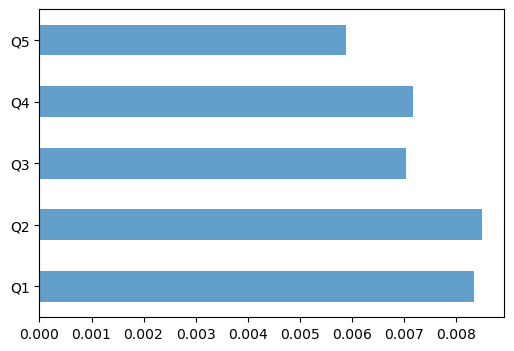

In [69]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1)

beta_portfolios.plot.barh(alpha=0.7)

### Wrap-up

* High-beta stocks in Q5 earn slightly lower average returns than those in Q1 and Q2 (low-beta stocks) <br>
<br>
* This contradicts with the prediction in conditional CAPM

---

## 10.3 Predicting Stock Returns 

* One of the key tasks in empirical asset pricing is to predict individual stock returns. <br>
<br>
* In this section, we focus on the cross-sectional predictability, i.e., whether small firms earn higher average returns than large firms?   <br>
<br>
* We answer this question by simple OLS regressions. The baseline model we want to estimate is: <br>
<br>
$$
R_{i,t+1} = c + X^\top_{it} \beta + \epsilon_{i,t+1}, 
$$
* $R_{i,t+1}$: return of stock $i$ at time $t+1$
* $X_{it}$: the $K \times 1$ vector of signals of stock $i$ at time $t$ (i.e., we are living at time $t$ and observe $X_{it}$. We aim to predict the next-period $R_{i,t+1}$)
* The key parameter is $\beta$ : if $\beta_k$ ($1 \leq k \leq K$) is significantly different from zero, we can say that the $k$-th signal can predict stock returns. 

### 10.3.1 Load the panel data of HK stocks and Preprocess the data

In [70]:
D = pd.read_parquet('data/HK_stocks_151signals.parquet', engine='pyarrow')
print(D.shape)

(413279, 154)


In [71]:
#D[['id', 'eom', 'market_equity']]

In [72]:
print(D.columns)
D.head()

Index(['id', 'eom', 'ret_exc_lead1m', 'cowc_gr1a', 'oaccruals_at',
       'oaccruals_ni', 'seas_16_20na', 'taccruals_at', 'taccruals_ni',
       'capex_abn',
       ...
       'eqnetis_at', 'eqnpo_12m', 'eqnpo_me', 'eqpo_me', 'fcf_me', 'ival_me',
       'netis_at', 'ni_me', 'ocf_me', 'sale_me'],
      dtype='object', length=154)


,id,eom,ret_exc_lead1m,cowc_gr1a,oaccruals_at,oaccruals_ni,seas_16_20na,taccruals_at,taccruals_ni,capex_abn,...,eqnetis_at,eqnpo_12m,eqnpo_me,eqpo_me,fcf_me,ival_me,netis_at,ni_me,ocf_me,sale_me
13581256,310108801.0,1990-07-31,-0.094007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.033708,NaN,NaN,NaN,NaN,NaN,0.093894,NaN,0.139606
13581257,310108801.0,1990-08-31,-0.145700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.033708,NaN,NaN,NaN,NaN,NaN,0.102937,NaN,0.153052
13581258,310108801.0,1990-09-30,0.151076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.033708,NaN,NaN,NaN,NaN,NaN,0.119655,NaN,0.177908
13581259,310108801.0,1990-10-31,0.017782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.034204,NaN,NaN,NaN,NaN,NaN,0.104479,NaN,0.155344
13581260,310108801.0,1990-11-30,0.020163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.034204,NaN,NaN,NaN,NaN,NaN,0.102087,NaN,0.151787


#### First, let's focus on the subsample between Jan 2000 and Dec 2020

In [73]:
D = D[(D.eom>='2000-01') & (D.eom<'2021-01')]

In [74]:
D = D.set_index(['id', 'eom'])  # create a hierarchical index using two columns 'id' and 'eom' as the index. 
D

ret_exc_lead1m  cowc_gr1a  oaccruals_at  oaccruals_ni  \
id          eom                                                                 
310108801.0 2000-01-31        0.048838   0.015783      0.057819      0.297865   
            2000-02-29        0.120655   0.015783      0.057819      0.297865   
            2000-03-31       -0.206566   0.015783      0.057819      0.297865   
            2000-04-30       -0.229319   0.015752      0.358486      1.048355   
            2000-05-31        0.206311   0.015752      0.358486      1.048355   
...                                ...        ...           ...           ...   
333190801.0 2020-08-31       -0.103452   0.033244      0.051367      0.215893   
            2020-09-30        0.114601   0.033244      0.051367      0.215893   
            2020-10-31        0.017469   0.034571      0.055404      0.202141   
            2020-11-30       -0.034063   0.034571      0.055404      0.202141   
            2020-12-31       -0.017632   0.034571      0.055404      0.202141   

                        seas_16_20na  taccruals_at  taccruals_ni  capex_abn  \
id          eom                                                               
310108801.0 2000-01-31           NaN      0.334973      1.725669        NaN   
            2000-02-29           NaN      0.334973      1.725669        NaN   
            2000-03-31           NaN      0.334973      1.725669        NaN   
            2000-04-30           NaN      0.637979      1.865701   1.139721   
            2000-05-31           NaN      0.637979      1.865701   1.139721   
...                              ...           ...           ...        ...   
333190801.0 2020-08-31           NaN     -0.038681     -0.162575   0.424967   
            2020-09-30           NaN     -0.038681     -0.162575   0.424967   
            2020-10-31           NaN     -0.033019     -0.120470   0.424967   
            2020-11-30           NaN     -0.033019     -0.120470   0.424967   
            2020-12-31           NaN     -0.033019     -0.120470   0.424967   

                        debt_gr3  fnl_gr1a  ...  eqnetis_at  eqnpo_12m  \
id          eom                             ...                          
310108801.0 2000-01-31  0.098660  0.014801  ...         NaN   0.018260   
            2000-02-29  0.098660  0.014801  ...         NaN   0.018260   
            2000-03-31  0.098660  0.014801  ...         NaN   0.018260   
            2000-04-30  0.055444  0.014718  ...         NaN   0.018260   
            2000-05-31  0.055444  0.014718  ...         NaN   0.017660   
...                          ...       ...  ...         ...        ...   
333190801.0 2020-08-31 -0.184604  0.023118  ...    0.271811   0.039263   
            2020-09-30 -0.184604  0.023118  ...    0.271811   0.039263   
            2020-10-31 -0.184604  0.023285  ...    0.271811   0.039263   
            2020-11-30 -0.184604  0.023285  ...    0.271811   0.039263   
            2020-12-31 -0.184604  0.023285  ...    0.271811   0.040079   

                        eqnpo_me   eqpo_me    fcf_me   ival_me  netis_at  \
id          eom                                                            
310108801.0 2000-01-31       NaN       NaN  0.004774  0.226013       NaN   
            2000-02-29       NaN       NaN  0.004533  0.214610       NaN   
            2000-03-31       NaN       NaN  0.004029  0.190759       NaN   
            2000-04-30       NaN       NaN -0.030523  3.880564       NaN   
            2000-05-31       NaN       NaN -0.039856  5.067118       NaN   
...                          ...       ...       ...       ...       ...   
333190801.0 2020-08-31 -0.120776  0.070716  0.135990  1.967647  0.272167   
            2020-09-30 -0.134701  0.078869  0.151669  2.194506  0.272167   
            2020-10-31 -0.120843  0.070755  0.159228  1.968742  0.272167   
            2020-11-30 -0.118761  0.069536  0.156484  1.934816  0.272167   
            2020-12-31 -0.123042  0.072042  0.162124  2.004556  0.2

#### Second, we further remove the firms that do not have enough historic observations available

* For instance, if a firm is included in the sample, it should have at least 12 observations. 

In [75]:
history_lengths = D.index.to_frame()['id'].groupby(level=0).count()

In [76]:
history_lengths

id
301393202.0    115
301510501.0      8
301549801.0    252
301553001.0    252
301565201.0    252
              ... 
334597601.0      1
334600201.0      1
334600301.0      1
334600401.0      1
334612501.0      1
Name: id, Length: 2773, dtype: int64

In [77]:
cs_idx_with_history = history_lengths[history_lengths >= 24].index 
ts_idx = D.index.get_level_values(1).unique()
df_idx = pd.MultiIndex.from_product((ts_idx, cs_idx_with_history)).to_frame()[[]]
        
# left merge to produce a balanced panel
D_full = pd.merge(D, df_idx, how='inner', left_index=True, right_index=True)

In [78]:
D_full

ret_exc_lead1m  cowc_gr1a  oaccruals_at  oaccruals_ni  \
id          eom                                                                 
310108801.0 2000-01-31        0.048838   0.015783      0.057819      0.297865   
            2000-02-29        0.120655   0.015783      0.057819      0.297865   
            2000-03-31       -0.206566   0.015783      0.057819      0.297865   
            2000-04-30       -0.229319   0.015752      0.358486      1.048355   
            2000-05-31        0.206311   0.015752      0.358486      1.048355   
...                                ...        ...           ...           ...   
333183701.0 2020-08-31       -0.087502  -0.613156     -0.489703     -0.858629   
            2020-09-30       -0.069160  -0.613156     -0.489703     -0.858629   
            2020-10-31        0.000222  -0.167308     -0.186136     -0.202729   
            2020-11-30       -0.341308  -0.167308     -0.186136     -0.202729   
            2020-12-31       -0.285791  -0.167308     -0.186136     -0.202729   

                        seas_16_20na  taccruals_at  taccruals_ni  capex_abn  \
id          eom                                                               
310108801.0 2000-01-31           NaN      0.334973      1.725669        NaN   
            2000-02-29           NaN      0.334973      1.725669        NaN   
            2000-03-31           NaN      0.334973      1.725669        NaN   
            2000-04-30           NaN      0.637979      1.865701   1.139721   
            2000-05-31           NaN      0.637979      1.865701   1.139721   
...                              ...           ...           ...        ...   
333183701.0 2020-08-31           NaN     -0.455361     -0.798415   0.077146   
            2020-09-30           NaN     -0.455361     -0.798415   0.077146   
            2020-10-31           NaN      0.184912      0.201396   0.077146   
            2020-11-30           NaN      0.184912      0.201396   0.077146   
            2020-12-31           NaN      0.184912      0.201396   0.077146   

                        debt_gr3  fnl_gr1a  ...  eqnetis_at     eqnpo_12m  \
id          eom                             ...                             
310108801.0 2000-01-31  0.098660  0.014801  ...         NaN  1.826049e-02   
            2000-02-29  0.098660  0.014801  ...         NaN  1.826049e-02   
            2000-03-31  0.098660  0.014801  ...         NaN  1.826049e-02   
            2000-04-30  0.055444  0.014718  ...         NaN  1.826049e-02   
            2000-05-31  0.055444  0.014718  ...         NaN  1.765956e-02   
...                          ...       ...  ...         ...           ...   
333183701.0 2020-08-31 -0.606049 -0.036384  ...         NaN  5.551115e-16   
            2020-09-30 -0.606049 -0.036384  ...         NaN  2.775558e-16   
            2020-10-31 -0.896877 -0.371048  ...         NaN -4.401689e-02   
            2020-11-30 -0.896877 -0.371048  ...         NaN -4.401689e-02   
            2020-12-31 -0.896877 -0.371048  ...         NaN -4.401689e-02   

                        eqnpo_me  eqpo_me    fcf_me   ival_me  netis_at  \
id          eom                                                           
310108801.0 2000-01-31       NaN      NaN  0.004774  0.226013       NaN   
            2000-02-29       NaN      NaN  0.004533  0.214610       NaN   
            2000-03-31       NaN      NaN  0.004029  0.190759       NaN   
            2000-04-30       NaN      NaN -0.030523  3.880564       NaN   
            2000-05-31       NaN      NaN -0.039856  5.067118       NaN   
...                          ...      ...       ...       ...       ...   
333183701.0 2020-08-31       NaN      NaN -0.029965       NaN       NaN   
            2020-09-30       NaN      NaN -0.032835       NaN       NaN   
            2020-10-31       NaN      NaN -0.033753       NaN       NaN   
            2020-11-30       NaN      NaN -0.033743       NaN       NaN   
            2020-12-31       NaN      Na

#### Third, we need to remove some extremely small firms

* For instance, if a firm's market capitalization is less than 0.001% of the total market capitalization of the whole HK stock market, we will exclude this firm from our analysis.  <br>
<br>
* Reason: Micro-cap firms often have extreme behaviors and are illiquid, which makes trading these stocks costly. 

In [79]:
total_market_cap = D_full['market_equity'].groupby(level=1).sum()

In [80]:
market_cap_filter = (D_full['market_equity'] / total_market_cap) > 0.00001

In [81]:
D_full = D_full[market_cap_filter]

In [82]:
D_full

ret_exc_lead1m  cowc_gr1a  oaccruals_at  oaccruals_ni  \
id          eom                                                                 
310108801.0 2000-01-31        0.048838   0.015783      0.057819      0.297865   
            2000-02-29        0.120655   0.015783      0.057819      0.297865   
            2000-03-31       -0.206566   0.015783      0.057819      0.297865   
            2000-04-30       -0.229319   0.015752      0.358486      1.048355   
            2000-05-31        0.206311   0.015752      0.358486      1.048355   
...                                ...        ...           ...           ...   
333183701.0 2018-11-30       -0.105329  -0.209154      0.528659      6.997669   
            2018-12-31       -0.146483  -0.209154      0.528659      6.997669   
            2019-03-31       -0.137475  -0.108815      0.528659      6.997669   
            2019-04-30       -0.129850   0.127135      0.439295     12.512152   
            2019-05-31       -0.047551   0.127135      0.439295     12.512152   

                        seas_16_20na  taccruals_at  taccruals_ni  capex_abn  \
id          eom                                                               
310108801.0 2000-01-31           NaN      0.334973      1.725669        NaN   
            2000-02-29           NaN      0.334973      1.725669        NaN   
            2000-03-31           NaN      0.334973      1.725669        NaN   
            2000-04-30           NaN      0.637979      1.865701   1.139721   
            2000-05-31           NaN      0.637979      1.865701   1.139721   
...                              ...           ...           ...        ...   
333183701.0 2018-11-30           NaN      0.563898      7.464126   1.927060   
            2018-12-31           NaN      0.563898      7.464126   1.927060   
            2019-03-31           NaN      0.563898      7.464126   1.927060   
            2019-04-30           NaN      0.428924     12.216765  -0.206262   
            2019-05-31           NaN      0.428924     12.216765  -0.206262   

                        debt_gr3  fnl_gr1a  ...  eqnetis_at     eqnpo_12m  \
id          eom                             ...                             
310108801.0 2000-01-31  0.098660  0.014801  ...         NaN  1.826049e-02   
            2000-02-29  0.098660  0.014801  ...         NaN  1.826049e-02   
            2000-03-31  0.098660  0.014801  ...         NaN  1.826049e-02   
            2000-04-30  0.055444  0.014718  ...         NaN  1.826049e-02   
            2000-05-31  0.055444  0.014718  ...         NaN  1.765956e-02   
...                          ...       ...  ...         ...           ...   
333183701.0 2018-11-30 -0.170135 -0.175539  ...         NaN  0.000000e+00   
            2018-12-31 -0.170135 -0.175539  ...         NaN  2.220446e-16   
            2019-03-31 -0.170135 -0.061488  ...         NaN  2.220446e-16   
            2019-04-30 -0.392954 -0.122736  ...         NaN  2.220446e-16   
            2019-05-31 -0.392954 -0.122736  ...         NaN  0.000000e+00   

                        eqnpo_me  eqpo_me    fcf_me   ival_me  netis_at  \
id          eom                                                           
310108801.0 2000-01-31       NaN      NaN  0.004774  0.226013       NaN   
            2000-02-29       NaN      NaN  0.004533  0.214610       NaN   
            2000-03-31       NaN      NaN  0.004029  0.190759       NaN   
            2000-04-30       NaN      NaN -0.030523  3.880564       NaN   
            2000-05-31       NaN      NaN -0.039856  5.067118       NaN   
...                          ...      ...       ...       ...       ...   
333183701.0 2018-11-30       NaN      NaN -0.203585       NaN       NaN   
            2018-12-31       NaN      NaN -0.227063       NaN       NaN   
            2019-03-31       NaN      NaN -0.196687       NaN       NaN   
            2019-04-30       NaN      NaN -0.165046       NaN       NaN   
            2019-05-31       NaN      Na

#### Fourth, we perform the rank-transformation of the firm characteristics. 

* Predictors are in different units and full of outliers, so we want to standardize the data.  <br>
<br>
* A standard practice is to rank and center each characteristic cross-sectionally to lie within the $[-0.5, 0.5]$ range.
  * In each month, we rank the stocks by their firm characteristic $k$ and divide their ranks by the number of stocks during this period. Finally, we substract it by 0.5. Hence, the rank-transformed firm characteristic $k$ is
  $$
  X_{ikt} = \frac{\text{rank}_{ikt}}{N_t} - 0.5
  $$
    * $\text{rank}_{ikt} \in [1, N_t]$: the rank of stock $i$ by the values of firm characteristic $k$
    * $N_t$: the number of stocks in period $t$

In [83]:
D_full.std()

ret_exc_lead1m     0.234235
cowc_gr1a         33.953999
oaccruals_at      30.774210
oaccruals_ni      86.045923
seas_16_20na       0.033897
                    ...    
ival_me            4.450667
netis_at           0.533379
ni_me              0.637378
ocf_me             0.610625
sale_me            4.639632
Length: 152, dtype: float64

In [84]:
D_full.abs().max()

ret_exc_lead1m       63.189411
cowc_gr1a          6067.371054
oaccruals_at       5506.954637
oaccruals_ni      25039.179853
seas_16_20na          0.597768
                      ...     
ival_me             726.091826
netis_at             37.009293
ni_me                28.208714
ocf_me               41.938109
sale_me             321.386311
Length: 152, dtype: float64

In [85]:
D_ranked = D_full.groupby(level=1).rank(ascending=True)
D_ranked = D_ranked / D_ranked.groupby(level=1).max() - 0.5

In [86]:
D_ranked.min()

ret_exc_lead1m   -0.499435
cowc_gr1a        -0.499288
oaccruals_at     -0.499291
oaccruals_ni     -0.499291
seas_16_20na     -0.496942
                    ...   
ival_me          -0.498926
netis_at         -0.498670
ni_me            -0.499435
ocf_me           -0.499435
sale_me          -0.499143
Length: 152, dtype: float64

#### Fifth, we need to handle missing data

* Remove the firm-month observations whenever the return is missing. 
  * In general, we do not fill in missing returns! <br>
<br>
* Remove the firm characteristics whose missing rates are higher than $30\%$ in any month. <br>
<br>
* For the remaining sample, we fill in missing data with zeros. 

In [87]:
D_ranked = D_ranked[D_ranked['ret_exc_lead1m'].isna() == False]

In [88]:
mis_rate = D_ranked.isna().groupby(level=1).mean()

In [89]:
D_ranked = D_ranked.loc[:,(mis_rate > 0.3).any()==False]

In [90]:
D_ranked = D_ranked.fillna(0)

In [91]:
D_ranked

ret_exc_lead1m  fnl_gr1a  nfna_gr1a    at_gr1  \
id          eom                                                         
310108801.0 2000-01-31        0.109848  0.196017   0.441300  0.472803   
            2000-02-29        0.320561  0.191667   0.443750  0.472973   
            2000-03-31       -0.062152  0.192149   0.442149  0.473196   
            2000-04-30       -0.358998  0.237374   0.435354  0.459759   
            2000-05-31        0.354244  0.241414   0.433333  0.459759   
...                                ...       ...        ...       ...   
333183701.0 2018-11-30       -0.303582 -0.474847   0.460123 -0.470482   
            2018-12-31       -0.414311 -0.473301   0.459951 -0.470273   
            2019-03-31       -0.426185 -0.373144   0.264233 -0.082878   
            2019-04-30       -0.234807 -0.432915  -0.058621 -0.229064   
            2019-05-31       -0.271290 -0.433540  -0.053416 -0.232764   

                         be_gr1a   inv_gr1  inv_gr1a  mispricing_mgmt  \
id          eom                                                         
310108801.0 2000-01-31  0.480220  0.405882  0.369198        -0.259916   
            2000-02-29  0.480435  0.406323  0.367647        -0.264706   
            2000-03-31  0.480519  0.404872  0.366667        -0.261317   
            2000-04-30  0.478903  0.371795  0.319106        -0.281563   
            2000-05-31  0.478814  0.369767  0.317073        -0.298403   
...                          ...       ...       ...              ...   
333183701.0 2018-11-30 -0.474831  0.000000 -0.142333         0.153024   
            2018-12-31 -0.475152  0.000000 -0.141914         0.190534   
            2019-03-31 -0.379257  0.000000 -0.099057        -0.041667   
            2019-04-30  0.042191  0.000000 -0.065663         0.105362   
            2019-05-31  0.042447  0.000000 -0.066396         0.049661   

                        ppeinv_gr1a  sale_gr1  ...       prc   ret_1_0  \
id          eom                                ...                       
310108801.0 2000-01-31     0.359375 -0.360759  ...  0.494361 -0.104563   
            2000-02-29     0.360000 -0.359539  ...  0.494393  0.108696   
            2000-03-31     0.354626 -0.362786  ...  0.494495  0.320561   
            2000-04-30     0.346154 -0.365580  ...  0.494495 -0.065056   
            2000-05-31     0.344017 -0.361507  ...  0.494516 -0.358998   
...                             ...       ...  ...       ...       ...   
333183701.0 2018-11-30    -0.112214 -0.258282  ... -0.143709 -0.003902   
            2018-12-31    -0.107116 -0.259540  ... -0.161376 -0.315476   
            2019-03-31     0.037279 -0.229981  ... -0.158434  0.491556   
            2019-04-30    -0.154957 -0.255306  ... -0.194172 -0.435236   
            2019-05-31    -0.157915 -0.253713  ... -0.204255 -0.245432   

                           at_me     be_me   bev_mev   debt_me  ebitda_mev  \
id          eom                                                              
310108801.0 2000-01-31 -0.334661 -0.249478 -0.235967 -0.252495   -0.168737   
            2000-02-29 -0.313861 -0.237060 -0.224638 -0.240079   -0.174897   
            2000-03-31 -0.332031 -0.258197 -0.251540 -0.251468   -0.170732   
            2000-04-30 -0.340691 -0.274194 -0.244980 -0.252896   -0.169339   
            2000-05-31 -0.312620 -0.211694 -0.171371 -0.234615   -0.162651   
...                          ...       ...       ...       ...         ...   
333183701.0 2018-11-30 -0.461171 -0.470874 -0.467026 -0.258788   -0.399308   
            2018-12-31 -0.451708 -0.468900 -0.462940 -0.252392   -0.410848   
            2019-03-31 -0.430556 -0.457317 -0.465473 -0.199450   -0.343909   
            2019-04-30 -0.420762 -0.453358 -0.468140 -0.237725   -0.231362   
            2019-05-31 -0.410530 -0.446979 -0.463684 -0.232759   -0.225641   

                           ni_me    ocf_me   sale_me  
id          eom                                       
310108801.0 2000-01-31  0.354582  0.

### 10.3.2 Simple OLS Regression Analysis

* After we preprocess the data, we end up with 47 variables in ```D_ranked```, 46 of which are signals (columns 2--47).  <br>
<br>
* We further divide the full sample into two subsamples: 
  * In-sample data: Jan 2000 - Dec 2015
  * Out-of-sample data: Jan 2016 - Dec 2020  <br>
<br>
* To assess predictive performance for individual excess stock return forecasts, we calculate the out-of-sample $R^2$ as <br>
<br>
$$
R^2_{oos} = 1 - \frac{\sum_{i,t \in \text{oos}} (R_{i,t+1} - \hat{R}_{i,t+1})^2}{\sum_{i,t \in \text{oos}} R^2_{i,t+1}}. 
$$
<br>
* $\sum_{i,t \in \text{oos}}$ indicates that fits are only assessed on the OOS subsample, whose data never enter into model estimation or tuning.   <br>
<br>
* $R^2_{oos}$ pools prediction errors across firms and over time into a grand panel-level assessment of each model.
   * Intuitively, it compares the model with the random walk hypothesis in which stocks are unpredictable and have zero mean returns.

In [92]:
D_ranked_in = D_ranked[(D_ranked.index.get_level_values(1) < '2016-01')]
D_ranked_oos = D_ranked[(D_ranked.index.get_level_values(1) >= '2016-01')]

In [93]:
data_in = pd.merge(D_full[['ret_exc_lead1m']], D_ranked_in, how='inner', left_index=True, right_index=True)
data_oos = pd.merge(D_full[['ret_exc_lead1m']], D_ranked_oos, how='inner', left_index=True, right_index=True)

#### Consider a simple case: Use ```['market_equity', 'be_me', 'ret_12_1']``` to predict stock returns

In [94]:
model = sm.OLS(data_in[['ret_exc_lead1m_x']].values, 
               sm.add_constant(data_in[['market_equity', 'be_me', 'ret_12_1']]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     72.94
Date:                Thu, 23 Nov 2023   Prob (F-statistic):           3.86e-47
Time:                        16:42:39   Log-Likelihood:                -13999.
No. Observations:              198947   AIC:                         2.801e+04
Df Residuals:                  198943   BIC:                         2.805e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0122      0.001     20.912

In [95]:
def get_R2(beta_hat, y, X):
    """
    beta_hat: a pandas.Series of coefficient estimates
    y: an ndarray of dependent variables
    X: a two-dimensional ndarray of independent variables
    This function returns the R-squared in the linear models
    """
    pred_err = y.reshape((len(y),)) - sm.add_constant(X) @ beta_hat
    return 1 - ((y.reshape(len(y),) - sm.add_constant(X) @ beta_hat)**2).sum() / (y**2).sum()


#### In-Sample Performance

In [96]:
get_R2(results.params, data_in[['ret_exc_lead1m_x']].values, 
       data_in[['market_equity', 'be_me', 'ret_12_1']].values)

0.003281287943694755

#### OOS Performance

$$
R^2_{oos} = 1 - \frac{\sum_{i,t \in \text{oos}} (R_{i,t+1} - \hat{R}_{i,t+1})^2}{\sum_{i,t \in \text{oos}} R^2_{i,t+1}}. 
$$

In [97]:
get_R2(results.params, data_oos[['ret_exc_lead1m_x']].values, 
       data_oos[['market_equity', 'be_me', 'ret_12_1']].values)

-0.005787789160073276

#### Use all 46 predictors

In [98]:
model = sm.OLS(data_in[['ret_exc_lead1m_x']].values, 
               sm.add_constant(data_in.iloc[:,2:]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     10.05
Date:                Thu, 23 Nov 2023   Prob (F-statistic):           4.72e-70
Time:                        16:42:39   Log-Likelihood:                -13877.
No. Observations:              198947   AIC:                         2.785e+04
Df Residuals:                  198900   BIC:                         2.833e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0083      0.001     

In [99]:
get_R2(results.params, data_oos[['ret_exc_lead1m_x']].values, 
       data_oos.iloc[:,2:].values)

-0.005633118253950187

### Conclusion

* OOS $R^2$ is always negative in previous analyses: Predicting stock returns using linear functions of these signals is even less efficient than the random walks, in which we just use zeros to predict returns. <br>
<br>
* All these signals are public information: Arbitrageurs have manipulated these opportunities in the past many years.  <br>
<br>
* Our model is too naive: Simple linear models fail to
    * Balance the bias-variance tradeoff in estimation
    * Capture the complex nonlinearity as in other methods (e.g., neural networks, tree-based regressions ...)

---

# END